## ETL Analytics With Immigration,Temparature and Airline/Airport Data

### Data Engineering Capstone Project

#### Project Summary
The capstone project aims at deriving analytics from the data loaded through ETL Process. It throws insight into the 
immigration i94 data,  airport codes/Airlines, weather patterns.

#### Following are data pattern being analyzed with the ETL data.
* Students to US from these countries
* Airlines landing in  US ports
* City Ports into US
* Visa Issuing Location in US
* Weather Trend
* Airports Statewise in US


#### The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

The scope of the project is the read the i94 immigration data, temparature data and Airport/Airlines details, clean the data, derive fact and dimension data models from the clean data, use ETL pipeline to load the data into fact and dimension tables, derive meaningful insights from the loaded data. The project is implemented in pyspark with the concepts learnt in Data lake section.

#### Describe and Gather Data

##### Datasets provided as a part of project:<br>
../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat  --------    US National Tourism and Trade Office.<br>
inputs/i94cit.json              --------    i94 Country of Citizenship & Country of Residence codes.<br>   
inputs/i94port.json             --------    US Port of Entry city names and their corresponding codes. <br>
inputs/airport-codes_csv.csv    --------    Airport codes and corresponding cities.<br>
inputs/world_temperature.csv    --------    Dataset contains temperature data of various cities<br>

##### Customized files from various other sources<br>
inputs/InternationalAirport.csv  --------   Airport codes taken from multiple sources<br>
inputs/visatype2.csv             --------   US Visa types codes		<br>
inputs/airline-codes.csv         --------   Airline codes and related details					<br>
inputs/visapost.csv              --------   Visa issuing post<br>
inputs/uszips.csv                --------   US Zipcodes database<br>
inputs/us-states.csv             --------   US States code<br>

#### Initialize Variables

In [1]:
import sys
!{sys.executable} -m pip install fuzzywuzzy[speedup]

In [2]:
import pandas as pd
import os
import glob
import pandas as pd
import numpy as np
import datetime as dt
import json
from fuzzywuzzy import fuzz, process
from time import time
import configparser
import matplotlib.pyplot as plt
import psycopg2
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, FloatType, TimestampType, LongType, DateType, NullType
import datetime #Required for ts conversion
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import *
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second
from pyspark.sql.functions import udf, lit, datediff, when, col

In [3]:
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
spark.sparkContext.getConf().getAll()
spark

In [4]:
# Panda options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 100)

#### Common Functions

In [5]:
def strip_all_columns(df):
    """
    Summary line.
    Strip all columns in a dataframe
    
    Parameters:
    arg1 (dataframe)
    
    Returns:
    dataframe
    """
    for colu in df.columns:
        if df[colu].dtype == 'object':            
            #print('COL = ',col,' - ',df[col].dtype)
            #df[col] = df[col].str.strip()           
            mask = df[colu].notnull()
            df.loc[mask, colu] = df.loc[mask, colu].map(str.strip)            
            #df[col] = df[col].map(str.strip)
    return df

def difference (list1, list2): 
    """
    Summary line. 
    Difference between two lists used to compare list of two sets of columns

    Parameters: 
    arg1 (list 1)
    arg2 (list 2)

    Returns: 
    list with difference
    
    Sample : print(difference(keep_columns, df_jan.columns))
    """                
    list_dif = [i for i in list1 + list2 if i not in list1 or i not in list2]
    return list_dif

def fuzzymatch_city_get_ratio(row):    
    """
    Summary line.
    Match city with US Cities list
    
    Parameters:
    arg1 (dataframe row)
    
    Returns:
    Panda series containing matched city name & score
    """
    city, state_code = row['City'], row['State Code']
    #print('City = ', city, 'State code = ',state_code)
    cities = df_uszips.loc[df_uszips.state_id==state_code, 'city'].str.lower().unique()    
    #print(process.extractOne(city, cities, scorer=fuzz.ratio))
    return pd.Series(process.extractOne(city, cities, scorer=fuzz.ratio))
def to_datetime(x):
    try:
        start = dt.datetime(1960, 1, 1).date()
        return start + dt.timedelta(days=int(x))
    except:
        return None
udf_to_datetime_sas = udf(lambda x: to_datetime(x), DateType())


def to_datetimefrstr(x):
    try:
        return dt.datetime.strptime(x, '%m%d%Y')
    except:
        return None

udf_to_datetimefrstr = udf(lambda x: to_datetimefrstr(x), DateType())

def cdf_Ymd_to_mmddYYYY(x):
    try:
        return dt.datetime.strptime(x, '%Y%m%d')
    except:
        return None

udf_cdf_Ymd_to_mmddYYYY = udf(lambda x: cdf_Ymd_to_mmddYYYY(x), DateType())

def cdf_mdY_to_mmddYYYY(x):
    try:
        return dt.datetime.strptime(x, '%m%d%Y')
    except:
        return None

udf_cdf_mdY_to_mmddYYYY = udf(lambda x: cdf_mdY_to_mmddYYYY(x), DateType())

#### Gather Data

In [6]:
# JSON to dictionary
fname = 'inputs/i94cit.json'
i94cit = json.load(open(fname))
fname = 'inputs/i94port.json'
i94port = json.load(open(fname))

# Airport Code Table
df_ac = pd.read_csv('inputs/airport-codes_csv.csv')

# Convert JSON Dictionaries to Dataframes
df_i94countrycode = pd.DataFrame(list(i94cit.items()), columns=['code', 'country'])
df_USPoE = pd.DataFrame(list(i94port.items()), columns=['code', 'citystate'])

# International Airports
df_iap = pd.read_csv('inputs/InternationalAirport.csv', sep=',', encoding = "ISO-8859-1")

# Visa Type
df_visatype = pd.read_csv('inputs/visatype2.csv', sep='|')

# World Temperature Data
df_temper = pd.read_csv('inputs/world_temperature.csv')

# Airliner Codes - Can be used join airline column in i94-immigration data
df_alc = pd.read_csv('inputs/airline-codes.csv')

# map to df_ids.visapost column
df_visapost = pd.read_csv('inputs/visapost.csv')

# US zip-codes
df_uszips = pd.read_csv('inputs/uszips.csv')

# US States
df_USstatecode = pd.read_csv('inputs/us-states.csv')


### Step 2: Explore and Assess the Data
#### Explore the Data & Cleaning Steps





In [7]:
# Read I94 SAS dataset
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

#### i94countrycode Cleaning

In [8]:
temp = ['MEXICO Air Sea, and Not Reported (I-94, no land arrivals)']
df_i94countrycode.loc[df_i94countrycode['country'].isin(temp), 'country']='MEXICO'
df_i94countrycode = df_i94countrycode[~df_i94countrycode.country.str.lower().str.contains('invalid')]
df_i94countrycode = df_i94countrycode[~df_i94countrycode.country.str.lower().str.contains('no country')]
df_i94countrycode = df_i94countrycode[~df_i94countrycode.country.str.lower().str.contains('collapsed')]

#### USPoE Cleaning

In [9]:
#USPoE Cleaning
df_USPoE["citystate"] = df_USPoE["citystate"].map(str.strip)
df_USPoE[['city', 'state']] = df_USPoE['citystate'].str.rsplit(",",n=1, expand=True)
df_USPoE = strip_all_columns(df_USPoE)
df_USPoE['state'] = df_USPoE.state.str.replace(r'\(.*\)$', '')
df_USPoE['state'] = df_USPoE['state'].str.replace('#ARPT', '')
df_USPoE['state'] = df_USPoE['state'].str.replace('#INTL', '')
df_USPoE['state'] = df_USPoE['state'].str.replace('WASHINGTON', 'WA')
df_USPoE['state'] = df_USPoE['state'].str.replace('MX', 'MEXICO')
df_USPoE['city'] = df_USPoE['city'].str.replace('#ARPT', '')
df_USPoE['city'] = df_USPoE['city'].str.replace('-ARPT', '')
df_USPoE['city'] = df_USPoE['city'].str.replace('ARPT', '')
df_USPoE['city'] = df_USPoE['city'].str.replace('INTL', '')
cond1 = df_USPoE.city.str.lower().str.contains('collapsed')
df_USPoE = df_USPoE[~cond1]
cond1 = df_USPoE.city.str.lower().str.contains('no port')
df_USPoE = df_USPoE[~cond1]
cond1 = df_USPoE.city.str.lower().str.contains('unknown')
df_USPoE = df_USPoE[~cond1]
cond1 = df_USPoE.city.str.lower().str.contains('identifi')
df_USPoE = df_USPoE[~cond1]
df_USPoE = df_USPoE[df_USPoE.state.str.len() == 2]
#print(df_USPoE)

#### airlines code cleaning

In [10]:
drop_cols = ['gps_code', 'ident']
#df_ac.drop(drop_cols, inplace = True, axis = 1)
df_ac = df_ac[df_ac.iso_country =='US']
temp = ['small_airport', 'medium_airport', 'large_airport']
df_ac = df_ac[df_ac['type'].isin(temp)]
df_ac[['longitude','latitude']] = df_ac.coordinates.str.split(", ",expand=True)
df_ac['state'] = df_ac.iso_region.str.slice(start=3)
for code in df_iap['IATA']:
    df_ac.loc[df_ac['iata_code'] == code, 'facilities'] = 'CI'
df_ac = df_ac[df_ac.facilities.notnull()].copy()
df_ac = df_ac[~df_ac.name.str.contains('uplicate')]


### copy dataframes for later use and conversion to spark dataframes

In [11]:
# Create copies of dataframe
dfd_i94countrycode = df_i94countrycode.copy()
# Running strip() on all string columns
dfd_i94countrycode =strip_all_columns(df_i94countrycode).copy()
df_i94countrycode = spark.createDataFrame(df_i94countrycode)
df_USPoE = spark.createDataFrame(df_USPoE)
df_ac = spark.createDataFrame(df_ac)

#### cleaning i94 data and building  details for fact table

In [12]:
# matflag is null
df_spark = df_spark.filter(df_spark.matflag.isNotNull())
# visatype GMT  
df_visatype=strip_all_columns(df_visatype)
temp = df_visatype.visatype.tolist()
df_spark = df_spark.filter( df_spark.visatype.isin(temp) )
# i94mode other than 1 2 3
temp = [1, 2, 3]
df_spark = df_spark.filter( df_spark.i94mode.isin(temp) )
# gender is null
df_spark = df_spark.filter(df_spark.gender.isNotNull())
# Remove rows having invalid CoC & CoR
temp = dfd_i94countrycode.code.astype('int').tolist()
df_spark = df_spark.filter( df_spark.i94cit.isin(temp) )
df_spark = df_spark.filter( df_spark.i94res.isin(temp) )



# df_USPoE : Remove invalid rows & ports outside US
df1 = df_USPoE.select('code')
df2 = df_spark.select('i94port')
temp = df2.subtract(df1) #.collect()
tempArr = [row.i94port for row in temp.collect()]
df_spark = df_spark.filter(~df_spark.i94port.isin(tempArr))


# Delete Port of Entries which lacks International Passenger Handling Facility operated by US Customs.
temp = df_ac.filter( df_ac.facilities.isNotNull() ).select('state').dropDuplicates()
df1 = [row.state for row in temp.collect()]
print('Total US States that has Customs & Immigration : ',len(df1))
temp = df_USPoE.filter(~df_USPoE.state.isin(df1)).select('code').dropDuplicates()
df2 = [row.code for row in temp.collect()]
print('Number of Port of Entries that needs to be deleted from df_USPoE : ',len(df2))
df_spark = df_spark.filter(~df_spark.i94port.isin(df2))

# Dropping unused columns
keep_columns = ['i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate'
                , 'i94bir', 'i94visa', 'dtadfile', 'visapost', 'occup', 'biryear'
                , 'dtaddto', 'gender', 'airline', 'admnum', 'fltno', 'visatype']
drop_cols = difference(keep_columns, df_spark.columns)
df_spark = df_spark.drop(*drop_cols)

# Convert floats to ints
cols_to_convert_float_to_integer = ['i94cit', 'i94res', 'arrdate', 'i94mode', 'depdate', 'i94bir'
                                , 'i94visa', 'biryear', 'admnum']
for colu in cols_to_convert_float_to_integer:    
    df_spark = df_spark.na.fill(0, subset=[colu])
    df_spark = df_spark.withColumn(colu, df_spark[colu].cast(IntegerType()))
    
# Mapping : Codes to descriptive
temp = [["1", "Air"], ["2", "Sea"], ["3","Land"], ["9", "Not reported"]]
i94mode = spark.sparkContext.parallelize(temp).toDF(["code", "arrival_mode"])
df_spark = df_spark.join(i94mode, df_spark.i94mode == i94mode.code).select(df_spark["*"], i94mode["arrival_mode"])

temp = [["1", "Business"], ["2", "Pleasure"], ["3", "Student"]]
i94visa = spark.sparkContext.parallelize(temp).toDF(["code", "visit_purpose"])
df_spark = df_spark.join(i94visa, df_spark.i94visa == i94visa.code).select(df_spark["*"], i94visa["visit_purpose"])

# Conversion of SAS encoded dates(arrdate & depdate)
df_spark = df_spark.withColumn("arrival_dt", udf_to_datetime_sas(df_spark.arrdate))
df_spark = df_spark.withColumn("departure_dt", udf_to_datetime_sas(df_spark.depdate))

df_spark = df_spark.withColumn("DaysinUS", datediff("departure_dt", "arrival_dt"))

df_spark = df_spark.withColumn("added_to_i94", udf_cdf_Ymd_to_mmddYYYY(df_spark.dtadfile))
df_spark = df_spark.withColumn("allowed_until", udf_cdf_mdY_to_mmddYYYY(df_spark.dtaddto))

# Below corrections are carried out due to above adding 1960-01-01
df_spark = df_spark.withColumn("arrival_dt",when(col("arrival_dt")=="1960-01-01",lit(None)).otherwise(col("arrival_dt")))
df_spark = df_spark.withColumn("departure_dt",when(col("departure_dt")=="1960-01-01",lit(None)).otherwise(col("departure_dt")))
df_spark = df_spark.withColumn("DaysinUS",when(col("arrival_dt").isNull(),lit(None)).otherwise(col("DaysinUS")))
df_spark = df_spark.withColumn("DaysinUS",when(col("departure_dt").isNull(),lit(None)).otherwise(col("DaysinUS")))

# Columns Rename
df_spark = (df_spark
            .withColumnRenamed("i94bir",  "age")
            .withColumnRenamed("i94cit", "CoC")
            .withColumnRenamed("i94res", "CoR")
            .withColumnRenamed("i94port", "PoE")
            .withColumnRenamed("i94addr", "landing_state")
            .withColumnRenamed("visapost", "visa_issued_in"))

# Entry_Exit
df_spark = df_spark.withColumn("entry_exit",when(col("departure_dt").isNull(),lit("entry")).otherwise(lit("exit")))

# Gender X to O
df_spark = df_spark.withColumn("gender", when(col("gender")=="X", lit("O")).otherwise(col("gender")))


# Final Drop of unused columns
drop_cols = ['i94mode', 'i94visa', 'arrdate', 'depdate', 'dtadfile', 'dtaddto']
#print(drop_cols)
df_spark = df_spark.drop(*drop_cols)



Total US States that has Customs & Immigration :  40
Number of Port of Entries that needs to be deleted from df_USPoE :  102


#### cleaning temparature data

In [13]:
#print(df_temper)
# Keeping only USA
df_temper = df_temper[df_temper.Country=='United States'].copy()

# Rounding temperature to decimals=3 
df_temper['AverageTemperature'] = df_temper['AverageTemperature'].round(decimals=3)

# Removing missing temperatures
df_temper = df_temper[~(df_temper.AverageTemperature.isnull())]

# Eliminating the duplicates(ie., multiple locations in same city)
df_temper = df_temper.drop_duplicates(['dt', 'City', 'Country'],keep= 'first')

# Convert dt to datetime from object
df_temper['dt'] = pd.to_datetime(df_temper.dt)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

#### <a href="conceptial_data_model.jpg" style="color: #cc0000">Click here for Conceptial Data Model</a>




#### 3.2 Mapping Out Data Pipelines
Steps necessary to pipeline the data into the chosen data model

    * Wrangle and Clean the data to identify valid data.
    * Design the conceptial data model.
    * Run pipline to create and load the following data model
        Dimension Tables:
            visatype_dim,airportcode_dim,USPoE_dim,uszips_dim,i94countrycode_dim,temper_dim,worldcities_dim,alc_dim,iap_dim,
            USstatecode_dim,visapost_dim,country_dim

     * Fact Tables:
        i94data_fact
     * Save processed dimension and fact tables in parquet for downstream query

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [14]:
print("cleaned Datasets")

df_spark.createOrReplaceTempView("i94data_fact")
i94data_fact = spark.sql("select * from i94data_fact")

df_visatype = spark.createDataFrame(df_visatype)
df_visatype.createOrReplaceTempView("visatype_dim")
visatype_dim = spark.sql("select * from visatype_dim")

df_ac.createOrReplaceTempView("airportcode_dim")
airportcode_dim = spark.sql("select * from airportcode_dim")
df_USPoE.createOrReplaceTempView("USPoE_dim")
USPoE_dim = spark.sql("select * from USPoE_dim")

df_uszips = spark.createDataFrame(df_uszips)
df_uszips.createOrReplaceTempView("uszips_dim")
uszips_dim = spark.sql("select * from uszips_dim")


df_temper = spark.createDataFrame(df_temper)
df_temper.createOrReplaceTempView("temper_dim")
temper_dim = spark.sql("select * from temper_dim")


print("Datasets with no changes/updates")
schema = StructType([StructField("code", StringType(), True)\
                   ,StructField("description",StringType(), True)])
df_alc = spark.createDataFrame(df_alc,schema)
df_alc.createOrReplaceTempView("alc_dim")
alc_dim = spark.sql("select * from alc_dim")




schema2 = StructType([StructField("code", StringType(), True)\
                   ,StructField("state",StringType(), True)\
                   ,StructField("status",StringType(), True)\
                   ,StructField("Unnamed_3",StringType(), True) ])

df_USstatecode = spark.createDataFrame(df_USstatecode,schema2)
df_USstatecode.createOrReplaceTempView("USstatecode_dim")
USstatecode_dim = spark.sql("select * from USstatecode_dim")

df_visapost = spark.createDataFrame(df_visapost)
df_visapost.createOrReplaceTempView("visapost_dim")
visapost_dim = spark.sql("select * from visapost_dim")

df_i94countrycode.createOrReplaceTempView("country_dim")
country_dim = spark.sql("select * from country_dim")

cleaned Datasets
Datasets with no changes/updates


In [15]:
i94data_fact.printSchema()
visatype_dim.printSchema()
USPoE_dim.printSchema()
uszips_dim.printSchema()
temper_dim.printSchema()
alc_dim.printSchema()
USstatecode_dim.printSchema()
visapost_dim.printSchema()
country_dim.printSchema()

root
 |-- CoC: integer (nullable = true)
 |-- CoR: integer (nullable = true)
 |-- PoE: string (nullable = true)
 |-- landing_state: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- visa_issued_in: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: integer (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)
 |-- arrival_mode: string (nullable = true)
 |-- visit_purpose: string (nullable = true)
 |-- arrival_dt: date (nullable = true)
 |-- departure_dt: date (nullable = true)
 |-- DaysinUS: integer (nullable = true)
 |-- added_to_i94: date (nullable = true)
 |-- allowed_until: date (nullable = true)
 |-- entry_exit: string (nullable = false)

root
 |-- visatype: string (nullable = true)
 |-- description: string (nullable = true)

root
 |-- code: string (nullable = true)
 |-- citystate: stri

In [17]:
i94data_fact.write.mode("append").partitionBy("PoE").parquet("results/fact.parquet")
visatype_dim.write.mode("append").partitionBy("visatype").parquet("results/visatype.parquet")
df_ac.write.mode("append").parquet("results/airportcode.parquet")
USPoE_dim.write.mode("append").parquet("results/USPoE.parquet")
uszips_dim.write.mode("append").parquet("results/uszips.parquet")
temper_dim.write.mode("append").parquet("results/temper.parquet")
alc_dim.write.mode("append").parquet("results/airlinecode.parquet")
USstatecode_dim.write.mode("append").parquet("results/USstatecode.parquet")
visapost_dim.write.mode("append").parquet("results/visapost.parquet")
country_dim.write.mode("append").parquet("results/i94countrycode.parquet")


In [18]:
#Top Students travelling to US from other countries:
spark.sql("SELECT  country_dim.country as country ,count(i94data_fact.visatype) as visitors FROM i94data_fact inner join country_dim on i94data_fact.COC=country_dim.code where i94data_fact.visatype in ('F1','F2','F3') group by country_dim.country order by count(i94data_fact.visatype) desc limit 10").show()


+--------------+--------+
|       country|visitors|
+--------------+--------+
|    CHINA, PRC|    7711|
|        MEXICO|    1536|
|        BRAZIL|    1226|
|         JAPAN|    1224|
|  SAUDI ARABIA|    1101|
|         INDIA|     917|
|        TAIWAN|     729|
|     VENEZUELA|     637|
|        FRANCE|     551|
|UNITED KINGDOM|     512|
+--------------+--------+



In [20]:
#Top Airlines landing in US ports
spark.sql("SELECT  country_dim.country as country ,count(i94data_fact.visatype) as visitors FROM i94data_fact inner join country_dim on i94data_fact.COC=country_dim.code where i94data_fact.visatype in ('F1','F2','F3') group by country_dim.country order by count(i94data_fact.visatype) desc limit 10").show()

+--------------+--------+
|       country|visitors|
+--------------+--------+
|    CHINA, PRC|    7711|
|        MEXICO|    1536|
|        BRAZIL|    1226|
|         JAPAN|    1224|
|  SAUDI ARABIA|    1101|
|         INDIA|     917|
|        TAIWAN|     729|
|     VENEZUELA|     637|
|        FRANCE|     551|
|UNITED KINGDOM|     512|
+--------------+--------+



In [22]:
#Top Visa Issuing locations into US
spark.sql("SELECT  visapost_dim.location as location,count(i94data_fact.visa_issued_in) as visitors FROM i94data_fact inner join visapost_dim on i94data_fact.visa_issued_in=visapost_dim.code group by visapost_dim.location order by count(i94data_fact.visa_issued_in)  desc limit 10").show()

+--------------+--------+
|      location|visitors|
+--------------+--------+
|   Mexico City|   77173|
|     Sao Paulo|   60445|
|  Buenos Aires|   59953|
|        Bogota|   42383|
|     Guangzhou|   41271|
|       Caracas|   33004|
|      Shanghai|   32431|
|       Beijing|   32294|
|   Guadalajara|   27770|
|Rio de Janeiro|   27517|
+--------------+--------+



In [23]:
#Temparature Trend of a City
spark.sql("select year(dt),avg(AverageTemperature) from temper_dim inner join uszips_dim on temper_dim.city=uszips_dim.city where temper_dim.city='Ann Arbor' group by year(dt) order by year(dt)").show()

+----------------------+-----------------------+
|year(CAST(dt AS DATE))|avg(AverageTemperature)|
+----------------------+-----------------------+
|                  1743|                  2.208|
|                  1744|     10.916624999999993|
|                  1745|    -0.8017499999999991|
|                  1750|      9.082818181818183|
|                  1751|               9.767625|
|                  1752|      1.694499999999999|
|                  1753|       8.50091666666667|
|                  1754|      8.725555555555554|
|                  1755|      5.585399999999998|
|                  1756|      9.068333333333337|
|                  1757|     7.9220000000000015|
|                  1758|                7.08175|
|                  1759|      8.027749999999996|
|                  1760|      6.438181818181816|
|                  1761|      8.991909090909088|
|                  1762|      8.521600000000001|
|                  1763|      6.080899999999999|
|                  1

In [27]:
#Most Visited State in US:
spark.sql("select state,count(i94data_fact.visatype) as visitors FROM i94data_fact inner join USstatecode_dim on i94data_fact.landing_state= USstatecode_dim.code group by state order by count(i94data_fact.visatype) desc limit 10 ").show()

+-------------+--------+
|        state|visitors|
+-------------+--------+
|      Florida|  463380|
|     New York|  402982|
|   California|  332854|
|       Hawaii|  116738|
|        Texas|   96538|
|       Nevada|   86689|
|     Illinois|   53710|
|   New Jersey|   53353|
|Massachusetts|   43215|
|   Washington|   34206|
+-------------+--------+



#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [18]:
# Perform existance of dimension and fact tables

def qc_df(df):
    if df is not None:
        return True
    else:
        return False
        
if qc_df(i94data_fact) & qc_df(visatype_dim) & qc_df(USPoE_dim) &  qc_df(uszips_dim) & qc_df(temper_dim) & qc_df(alc_dim)  & qc_df(df_visapost) &  qc_df(USstatecode_dim) & qc_df(visapost_dim) & qc_df(country_dim):
    print("data quality check passed")
    print("dimension tables and fact table exist")
    print()
else:
    print("data quality check failed")
    print("table missing...")

data quality check passed
dimension tables and fact table exist



In [19]:
# Perform non zero record count check

def qc_records(df):
    return df.count() != 0 

if qc_records(i94data_fact) & qc_records(visatype_dim) & qc_records(USPoE_dim) &  qc_records(uszips_dim) & qc_records(temper_dim) & qc_records(alc_dim)  & qc_records(df_visapost) &  qc_records(USstatecode_dim) & qc_records(visapost_dim) & qc_records(country_dim):
    print("data quality check passed!")
    print("dimension tables and fact table contain records")
    print()
else:
    print("data quality check failed!")
    print("null records...")

data quality check passed!
dimension tables and fact table contain records



#### 4.3 Data dictionary 
### <a href="dictionary.txt" style="color: #cc0000">Click here for Data Dictionary</a>

#### 4.4 Basic Data Visualization

Text(0.5,1,'Top Students to US are from these countries')

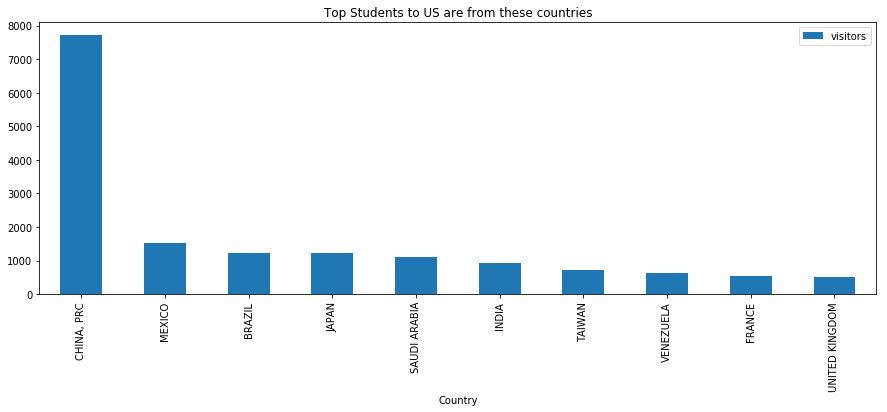

In [20]:
df_student =spark.sql("SELECT  country_dim.country as country ,count(i94data_fact.visatype) as visitors FROM i94data_fact inner join country_dim on i94data_fact.COC=country_dim.code where i94data_fact.visatype in ('F1','F2','F3') group by country_dim.country order by count(i94data_fact.visatype) desc limit 10").toPandas()
graph = df_student[['country','visitors']].plot(x='country',kind='bar', figsize=(15,5))
plt.xlabel('Country')
plt.title('Top Students to US are from these countries')


Text(0.5,1,'Top Tourist to US are from these countries')

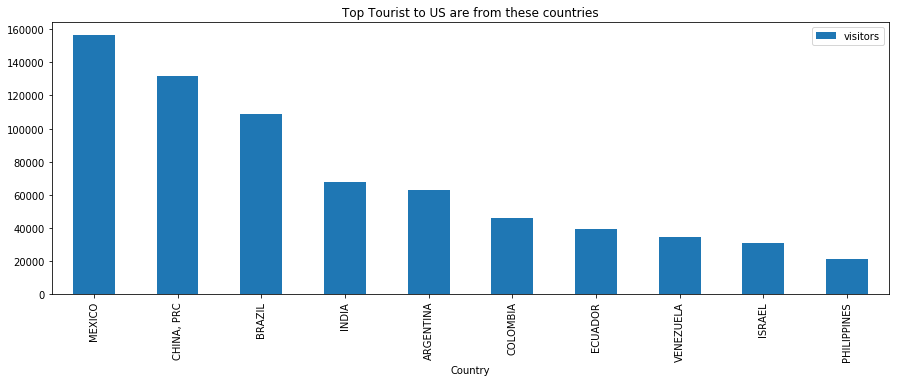

In [21]:
df_visitor =spark.sql("SELECT  country_dim.country as country,count(i94data_fact.visatype) as visitors FROM i94data_fact inner join country_dim on i94data_fact.COC=country_dim.code where i94data_fact.visatype in ('B1','B2') group by country_dim.country order by count(i94data_fact.visatype) desc limit 10").toPandas()
graph = df_visitor[['country','visitors']].plot(x='country',kind='bar', figsize=(15,5))
plt.xlabel('Country')
plt.title('Top Tourist to US are from these countries')

Text(0.5,1,'Top Airlines to US')

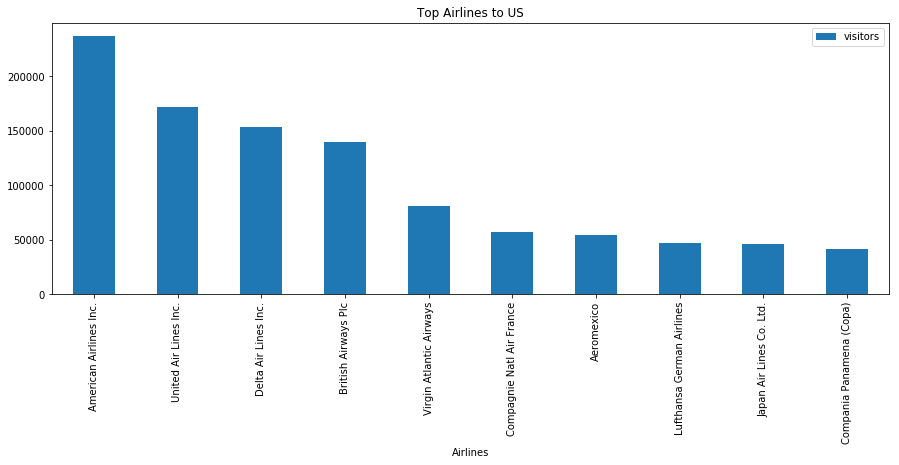

In [22]:
df_airline =spark.sql("SELECT  alc_dim.description as airline,count(i94data_fact.airline) as visitors FROM i94data_fact inner join alc_dim on i94data_fact.airline=alc_dim.code group by alc_dim.description order by count(i94data_fact.airline) desc limit 10").toPandas()
graph = df_airline[['airline','visitors']].plot(x='airline',kind='bar', figsize=(15,5))
plt.xlabel('Airlines')
plt.title('Top Airlines to US')

Text(0.5,1,'Top City Ports into US')

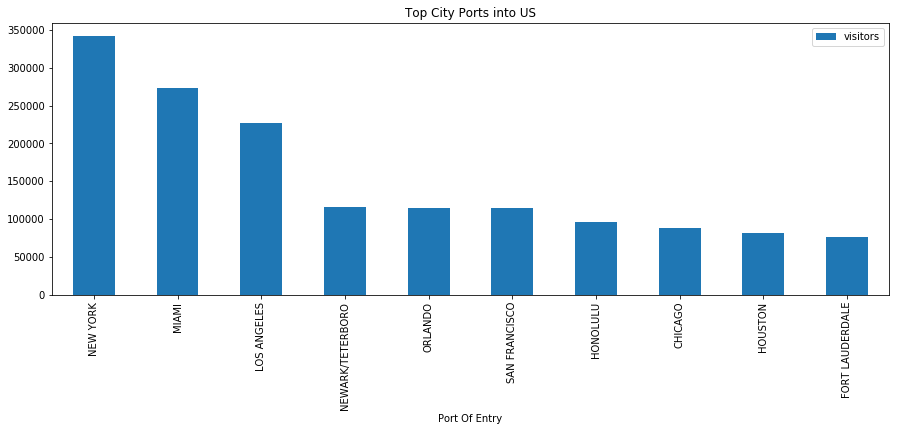

In [23]:
df_poe =spark.sql("SELECT  USPoE_dim.city as city,count(i94data_fact.PoE) as visitors FROM i94data_fact inner join USPoE_dim on i94data_fact.PoE=USPoE_dim.code group by USPoE_dim.city order by count(i94data_fact.PoE) desc limit 10").toPandas()
graph = df_poe[['city','visitors']].plot(x='city',kind='bar', figsize=(15,5))
plt.xlabel('Port Of Entry')
plt.title('Top City Ports into US')

Text(0.5,1,'Top Visa Issuing Location into US')

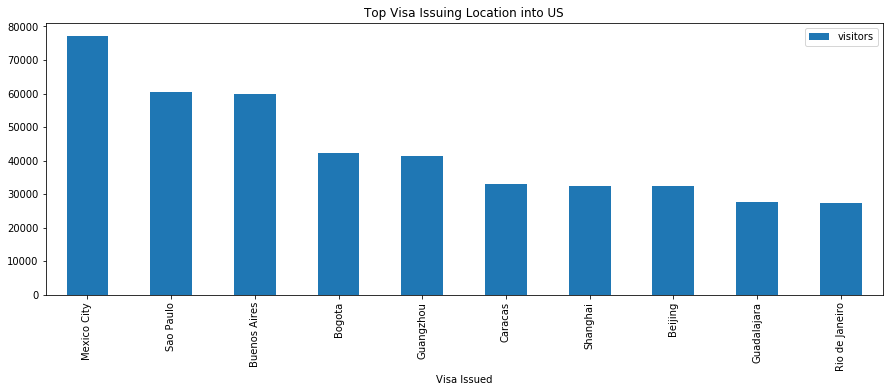

In [24]:
df_vpost =spark.sql("SELECT  visapost_dim.location as location,count(i94data_fact.visa_issued_in) as visitors FROM i94data_fact inner join visapost_dim on i94data_fact.visa_issued_in=visapost_dim.code group by visapost_dim.location order by count(i94data_fact.visa_issued_in)  desc limit 10").toPandas()
graph = df_vpost[['location','visitors']].plot(x='location',kind='bar', figsize=(15,5))
plt.xlabel('Visa Issued')
plt.title('Top Visa Issuing Location into US')


Text(0.5,1,'Top # Airports Statewise in US')

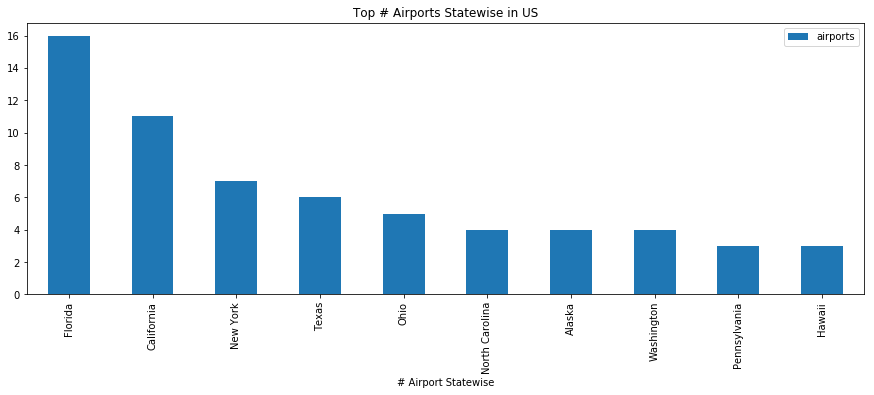

In [25]:
df_airportcode =spark.sql("select USstatecode_dim.state as state,count(iata_code) as airports from airportcode_dim inner join USstatecode_dim on airportcode_dim.state=USstatecode_dim.code group by USstatecode_dim.state order by count(iata_code) desc limit 10").toPandas()
graph = df_airportcode[['state','airports']].plot(x='state',kind='bar', figsize=(15,5))
plt.xlabel('# Airport Statewise')
plt.title('Top # Airports Statewise in US')

Text(0.5,1,'Weather Trend')

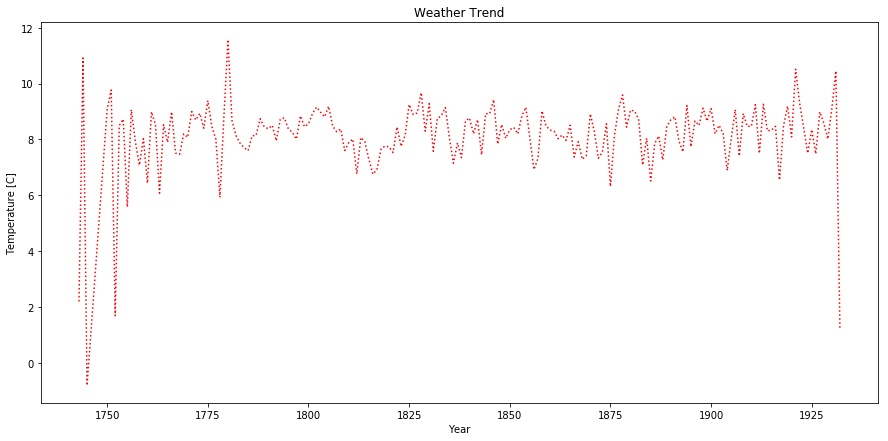

In [26]:
import matplotlib.pyplot as plt
df_temp =spark.sql("select year(dt),avg(AverageTemperature) from temper_dim inner join uszips_dim on temper_dim.city=uszips_dim.city where temper_dim.city='Ann Arbor' group by year(dt) order by year(dt) ").toPandas()
plt.rcParams['figure.figsize'] = [15, 7]
x = df_temp.iloc[:,0].tolist()
y = df_temp.iloc[:,1].tolist()
plt.plot(x, y, ':', label=f'Ann Arbor - 20 Year Avg',color='red')
plt.xlabel('Year')
plt.ylabel('Temperature [C]')
plt.title('Weather Trend')

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

PySpark is chosen for this project due to the following reasons    
* scale easily with additional worker nodes
* with ability to digest different data formats (e.g. SAS, Parquet, CSV)
* integration with cloud storage like S3 and warehouse like Redshift.
* Spark SQL was chosen to process the large input files into dataframes, crate tables and manipulated via standard SQL operations
* processing large amount of data fast (with in-memory compute) 
  
The captone project aims at developing ETL pipeline to organize and load the data into dimension and fact modelled tables from i94 immigration data, temparature data,Airport/Airlines and reference tables. The organized data will help in deriving 
* Pattern of the immigrants entering into USA, 
* Temparature patterns of various cities in USA which will help airlines to predict unusualy climate trends
* Trend of Airlines landing in the US Ports.
<a href="queries.txt" style="color: #cc0000">Click here for queries to derive data insights</a>


* Propose how often the data should be updated and why.

Data Updates are usually dependent on two critical factor. How often the business needs the data and the availability of the new data into the system.  i94data SAS data is likely to change frequently whereas the remaining tables may be more static reference tables and less likely to change frequently. Temparature data is likely to change every month. Given the scenerio data updates can be done weekly and reports generated on the monday to see any change in data.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     Some of options that can be considered to improve performance if the data increases 100 x
     * Store the data in S3 in parquet format which is a columnar data storage.
     * Processing the data on EMR cluster which gives the option to scale the platform according to the need
     * Moving Spark to cluster mode using a cluster manager such as Yarn.
     * Changing the data as increamental updates instead of full refresh.     

 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     * We can consider using Airflow to schedule and automate the data pipeline jobs. Built-in retry and monitoring mechanism can enable us to meet user requirement.
 * The database needed to be accessed by 100+ people.
     * We can consider hosting our solution in production scale data warehouse in the cloud like redshift, with larger capacity to serve more users, and workload management to ensure equitable usage of resources across users.
 